# Entrenamiento de redes neuronales con PyTorch


## Funciones de costo y optimizadores

Para entrenar una red neuronal debemos definir 

1. Una función de costo: Aquello que vamos a minimizar
1. Un algoritmo de optimización: De que forma vamos a minimizar

Las funciones de costo están implementadas [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions), a continuación revisaremos las dos más comunes. La clase [`MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) representa el error cuadrático medio. Se utiliza en problemas de regresión (etiqueta con valores reales) y se define como

$$
\mathcal{L}(y, \hat y) = \sum_{d=1}^D ( y_d - \hat y_d)^2
$$

donde $y$ es la etiqueta (vector con D dimensiones) e $\hat y$ es la predicción del modelo

:::{note}

Cuando entrenamos con esta función de costo debemos asegurarnos de que el modelo tenga tantas unidades de salida como dimensiones tenga la etiqueta

:::

La clase [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) representa la entropía cruzada. Esta función de costo se utiliza en problemas de clasificación de $C$ clases y se define como

$$
\mathcal{L}(y, \hat y) = - \sum_{c=1}^C  y_c \log (\hat y_c )
$$

donde $y_c \in \{0,1\}$, $\hat y_c \in [0,1]$ y $\sum_{c=1}^C \hat y_c = 1$

:::{note}

Cuando entrenamos con esta función de costo debemos asegurarnos de que el modelo tenga tantas unidades de salida como clases tenga el problema.  

:::

:::{warning}

La implementación de entropía cruzada de torch espera que las etiquetas $y$ estén en formato **categórico**, es decir como un entero con valor $0, 1, 2, \ldots, C-1$. Adicionalmente espera las predicciones $\hat y$ estén en formato **logits** (números reales sin activación)

:::


Luego de crear una instancia de estas clases las podemos llamar con una función. Por ejemplo si queremos calcular el error medio cuadrático entre dos tensores:

```python
criterion = torch.nn.MSELoss(reduction='mean')
loss = criterion(output, target)
```

:::{note}

También podemos crear nuestra propia función de costo. Por ejemplo podríamos lograr lo mismo que `MSELoss` habiendo definido `criterion = lambda ypred, y : (y-ypred).pow(2).mean()`

:::





Los algoritmos de optimización están implementados en el módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html). Hoy en día los más utilizados son

| Optimizador | Descripción |
| ---- | ---- |
| [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) | Gradiente descedente estocástico con momentum|
| [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) | Gradiente descedente con tasa de aprendizaje adaptiva |


Para crear un objeto optimizar debemos entregar como argumento los parámetros del modelo y las argumetnos específicos del optimizar, por ejemplo para SGD:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0, weight_decay=0)
```

donde:

- `lr` Es la tasa de aprendizaje. Debe ser un valor pequeño para no desestabilizar el entrenamiento, pero no tan pequeño para enlentencerlo demasiado
- `momentum` es la tasa de momentum. Podemos utilizar un valor mayor que cero para evitar estancamiento en mínimos locales
- `weight_decay` controla la regularización (norma L2) de los parámetros. Podemos utilizar un valor mayor que cero para evitar sobreajuste 

Una vez creado podemos llamar su función principal `step()` la cual realiza una actualización de parámetros de acuerdo a las derivadas calculadas con `loss.backward()`

## Ajustando un modelo paso a paso

Consideremos el siguiente dataset $X$ con etiqueta $Y$. El dataset tiene cuatro ejemplos separados en dos clases. Los ejemplos tienen cada uno dos atributos.

Utilizaremos `CrossEntropyLoss` para entrenar por lo tanto utilizamos dos unidades de salida

In [1]:
import torch
import torch.nn as nn

X = torch.tensor([[-1.0, -1.0],
                  [-1.0, 1.0],
                  [1.0, -1.0],
                  [1.0, 1.0]])
Y = torch.tensor([0, 0, 0, 1])

n_features = X.shape[1]
n_classes = len(Y.unique())
n_hidden = 3
model = nn.Sequential(nn.Linear(n_features, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_classes))

criterion = torch.nn.CrossEntropyLoss(reduction='sum')

model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3, out_features=2, bias=True)
)

Como optimizador utilizaremos el Adam

In [2]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Primero realizamos una predicción (inferencia) con:

In [3]:
hatY = model(X)
hatY

tensor([[0.4354, 0.4515],
        [0.2773, 0.5978],
        [0.4749, 0.5023],
        [0.3242, 0.6451]], grad_fn=<AddmmBackward0>)

Luego calculamos la función de pérdida:

In [4]:
loss = criterion(hatY, Y)
loss

tensor(2.8198, grad_fn=<NllLossBackward0>)

En seguida calculamos el gradiente de la función de pérdida:

In [5]:
loss.backward()

Los gradientes se guardan en el atributo `grad` de todos los pesos y sesgos (parámetros) de la red:

In [6]:
model[0].weight.grad, model[0].bias.grad

(tensor([[-0.0444, -0.0304],
         [-0.2247, -0.2020],
         [ 0.1995,  0.2430]]),
 tensor([ 0.0487,  0.3291, -0.2548]))

Finalmente actualizamos los parámetros usando la función `step` de nuestro optimizador

Los parámetros actuales de la primera capa son:

In [7]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.2944, -0.0764],
         [ 0.3081,  0.3902],
         [ 0.3516, -0.2495]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5336,  0.6175, -0.5518], requires_grad=True))

In [8]:
optimizer.step()

Los parámetros luego de hacer la actualización son:

In [9]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.3044, -0.0664],
         [ 0.3181,  0.4002],
         [ 0.3416, -0.2595]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5236,  0.6075, -0.5418], requires_grad=True))

:::{tip}

Para interpretar la salida de la red como probabilidades podemos aplicar una activación `nn.Softmax(dim=1)` como se muestra a continuación. 

:::

In [10]:
nn.Softmax(dim=1)(hatY).detach()

tensor([[0.4960, 0.5040],
        [0.4206, 0.5794],
        [0.4932, 0.5068],
        [0.4205, 0.5795]])

Cada columna representa a una clase y cada fila a un ejemplo. Los valores están siempre entre cero y uno, y además las filas suman uno

Más en general el proceso de ajuste se realiza iterativamente durante un cierto número de pasos o "épocas" de entrenamiento como se muestra a continuación:

In [11]:
for nepoch in range(1000):
    hatY = model.forward(X)
    optimizer.zero_grad()
    loss = criterion(hatY, Y)
    loss.backward()
    optimizer.step()
    if nepoch % 100 == 0:
        print(f"{nepoch} {loss.item():0.2f} {torch.nn.Softmax(dim=1)(hatY)[:, 1].detach()}")

0 2.75 tensor([0.4879, 0.5663, 0.4912, 0.5667])
100 0.94 tensor([0.0313, 0.2128, 0.1278, 0.5868])
200 0.21 tensor([0.0032, 0.0459, 0.0360, 0.8818])
300 0.08 tensor([0.0013, 0.0181, 0.0144, 0.9505])
400 0.05 tensor([7.1821e-04, 9.9393e-03, 7.9667e-03, 9.7200e-01])
500 0.03 tensor([4.8429e-04, 6.4070e-03, 5.1628e-03, 9.8162e-01])
600 0.02 tensor([3.5607e-04, 4.5233e-03, 3.6610e-03, 9.8685e-01])
700 0.02 tensor([2.7631e-04, 3.3863e-03, 2.7510e-03, 9.9006e-01])
800 0.01 tensor([2.2247e-04, 2.6408e-03, 2.1522e-03, 9.9218e-01])
900 0.01 tensor([1.8397e-04, 2.1223e-03, 1.7346e-03, 9.9367e-01])


:::{note}

Paso a paso, el error (función de costo) disminuye y la predicción del modelo se acerca a la etiqueta

:::

In [12]:
Y

tensor([0, 0, 0, 1])

## Entrenamiento por minibatches

Si el *dataset* del problema es de gran tamaño no es conveniente utilizar el conjunto completo para calcular la función de costo y derivar. 

En general actualizamos el modelo presentandole subconjuntos (*minibatches*) del dataset

:::{note}

Esto es lo que se conoce como la estimación estocástica del gradiente descedente (SGD)

:::

A continuación veremos algunas clases de PyTorch que facilitan la interacción entre el modelo y el conjunto de entrenamiento. A modo de ejemplo crearemos un conjunto de datos sintético con dos atributos, dos clases y que no es linealmente separable:

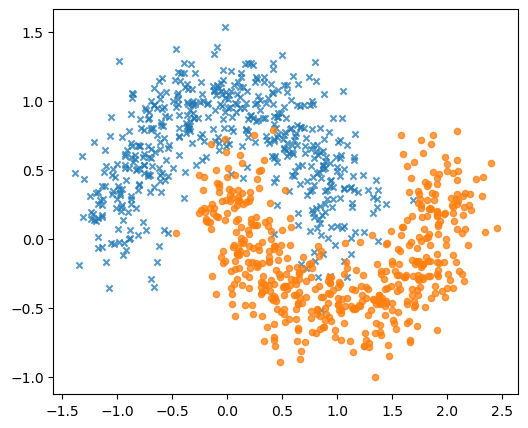

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

np.random.seed(0)
X, y = sklearn.datasets.make_moons(n_samples=1000, noise=0.2)

fig, ax = plt.subplots(figsize=(6, 5))
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], s=20, marker=marker, alpha=0.75)

El súbmodulo [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) tiene los objetos que facilitan la interacción con datos

Sus clases principales son 

- [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset): Clase abstracta que representa a un conjunto de datos
- [`Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset): Clase que representa una partición de un conjunto de datos, por ejemplo la partición de entrenamiento o validación
- [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset): Generador que recibe un conjunto de datos y retorna subconjuntos (minibatches) iterativamente


El primer paso es crear una clase que represente nuestro conjunto de datos en particular, esta clase debe heredar de `Dataset` y debe implementar las funciones `__len__` y `__getitem__`

In [54]:
import torch.utils.data as data

class MyDataset(data.Dataset):
    
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = torch.from_numpy(data.astype('float32'))
        self.labels = torch.from_numpy(labels.astype('int'))
        
    def __getitem__(self, idx: int):
        return (self.data[idx], self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    
dataset = MyDataset(X, y)

dataset[0], len(dataset)

((tensor([2.0861, 0.5740]), tensor(1)), 1000)

donde

- El constructor recibe los datos y los convierte en formato tensor
- `__getitem__`, recibe un índice y retorna una tupla (dato, etiqueta)
- `__len__` retorna la cantidad de ejemplos del conjunto de datos

Para crear particiones de este dataset podemos utilizar la función `random_split` del módulo `data`. Esta función recibe el dataset, los tamaños de cada partición y una semilla aleatoria

In [55]:
train_set, valid_set, test_set = data.random_split(dataset, [600, 200, 200], 
                                                   generator=torch.Generator().manual_seed(1234))

Finalmente creamos objetos `DataLoader` para obtener minibatches de entrenamiento, validación y prueba con:

In [56]:
train_loader = data.DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = data.DataLoader(valid_set, shuffle=False, batch_size=128)
test_loader = data.DataLoader(test_set, shuffle=False, batch_size=128)

Los argumentos principales de esta clase son:

- Un objeto `Dataset` o `Subset`
- `shuffle`: Booleano que índica si los ejemplos se muestran de forma ordenada o desordenada
- `batch_size`: Entero que indica la cantidad de ejemplos por *minibatch*

:::{important}

Es conveniente presentar el conjunto de entrenamiento en distinto orden en cada época. Utiliza `shuffle=True` para este conjunto. 

:::

Una vez creado el objeto `DataLoader` se puede ocupar de forma equivalente a otros iteradores de Python:

In [17]:
for batchx, batchy in train_loader:
    break
    
batchx.T, batchy

(tensor([[ 0.3830,  2.0515,  1.5669, -0.3935, -0.6647, -0.2609,  0.4318,  1.8250,
           1.6588,  0.5211,  1.9899,  0.3097,  1.6962, -0.3921,  0.9047,  1.0109,
           1.3994,  0.4290,  0.4270,  2.0872,  0.8484,  0.2736,  1.4052,  1.9087,
           0.7396, -1.1334,  2.3240, -0.0364,  1.0629, -1.1360, -0.2579,  0.1431],
         [-0.1692,  0.4767, -0.3619,  1.2033,  1.0936,  0.8748, -0.0486, -0.2704,
          -0.7356,  0.7499, -0.0038, -0.3112, -0.4479,  1.2724,  0.3506, -0.4762,
          -0.2553,  0.7101, -0.0494,  0.4275, -0.5171,  0.4301, -0.4316,  0.3939,
          -0.1827,  0.2478,  0.4465,  1.2197, -0.2574,  0.1693,  0.4656, -0.0320]]),
 tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 0, 1, 0, 1, 0, 1, 1]))

## Esquema general de entrenamiento en PyTorch

Habiendo definido el modelo, el criterio, el optimizador y los datos, el esquema general de entrenamiento de un modelo en PyTorch sería:

``` python
for epoch in range(num_epochs): # Durante un cierto número de épocas
    for minibatch in data: # Para cada minibatch de datos
        optimizer.zero_grad() # Limpiamos los gradientes
        x, y = minibatch # Desempaquetamos
        yhat = model.forward(x) # Predecimos
        loss = criterion(yhat, y) # Evaluamos
        loss.backward() # Calculamos los gradientes
        optimizer.step() # Actualizamos los parámetros
```

donde

- Una época es una presentación completa del conjunto de entrenamiento
- Un *minibatch* es un subconjunto del conjunto de entrenamiento


Adicionalmente, debemos considerar un bucle de validación donde sólo realizamos predicción y evaluación de la *loss* con el objetivo de detectar sobre-ajuste

Early Stopping
: Detención del entrenamiento cuando la loss de validación no haya disminuido durante una cierta cantidad de épocas (paciencia). Se utiliza para evitar el sobreajuste

:::{important}

En cada época, verifica que si el error de validación representa un nuevo mínimo. Si es así puedes respaldar el modelo utilizado [`torch.save`](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

:::

A continuaciones se ponen en práctica estos criterios utilizando PyTorch. Por conveniencia se implementan las siguientes funciones

- `update_step`: Recibe un minibatch  y actualiza los parámetros
- `evaluation_step`: Recibe un minibtach y evalúa el criterio de optimización
- `train_one_epoch`: Realiza una época de entrenamiento. Se encarga de guardar el modelo si es el mejor encontrado hasta ese punto


In [18]:
def update_step(data, label):
    prediction = model(data)
    optimizer.zero_grad()
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_step(data, label):
    prediction = model(data)
    loss = criterion(prediction, label)
    return loss.item()

def train_one_epoch(epoch):    
    train_loss, valid_loss = 0.0, 0.0    
    for batchx, batchy in train_loader:
        train_loss += update_step(batchx, batchy)    
    for batchx, batchy in valid_loader:
        valid_loss += evaluate_step(batchx, batchy)
        
    # Guardar modelo si es el mejor hasta ahora
    global best_valid_loss
    if epoch % 10 == 0:
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({'epoca': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, 
                       'best_model.pt')
    
    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)

:::{note}

Para entrenar en GPU sería necesario 

- que el modelo esté en memoría de GPU 
- enviar los datos y etiquetas a GPU antes de realizar los cálculos. 

:::


En este caso el modelo se entrena por 500 épocas

CPU times: user 24 s, sys: 6.63 ms, total: 24 s
Wall time: 3.01 s


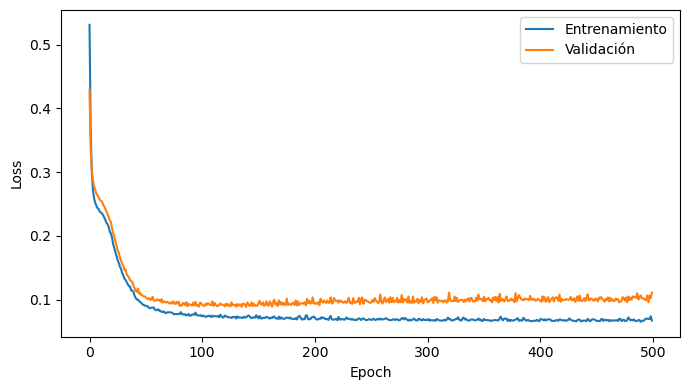

In [57]:
%%time

def my_model(n_hidden: int):
    return nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))

model = my_model(10)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

max_epochs, best_valid_loss = 500, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))

for epoch in range(max_epochs):
    running_loss[epoch] = train_one_epoch(epoch)
    
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

Cargamos la información serializada del modelo utilizado `torch.load`

In [58]:
saved_model = torch.load('best_model.pt')

El mejor modelo se obtuvo en la época

In [59]:
saved_model['epoca']

130

Podemos asignar los mejores parámetros al modelo anterior con:

In [60]:
model = my_model(10)
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

Podemos evaluar el mejor modelo en el conjunto de test para analizar su capacidad de generalización

In [61]:
from sklearn.metrics import classification_report

ytrue, ypred = [], []
for x, y_ in test_loader:
    ypred.append(nn.Softmax(dim=1)(model(x)).detach().argmax(dim=1))
    ytrue.append(y_)
ytrue, ypred = np.concatenate(ytrue), np.concatenate(ypred)

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       104
           1       0.95      0.96      0.95        96

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



En este caso también podemos visualizar el resultado de predicción en el espacio de características:

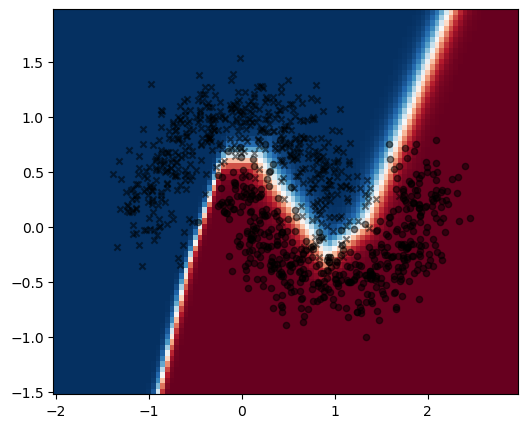

In [62]:
x1_test = np.arange(-2, 3, 0.05, dtype=np.float32)
x2_test = np.arange(-1.5, 2, 0.05, dtype=np.float32)
xx1_test, xx2_test = np.meshgrid(x1_test, x2_test)
x_test = torch.from_numpy(np.stack((xx1_test.ravel(), xx2_test.ravel())).T)

prob_test = nn.Softmax(dim=1)(model(x_test)).detach()[:, 1].reshape(xx1_test.shape)

fig, ax = plt.subplots(figsize=(6, 5))
ax.pcolormesh(x1_test, x2_test, prob_test, cmap=plt.cm.RdBu_r)
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], c='k', s=20, marker=marker, alpha=0.5)

El resultado en la capa de salida tiene forma circular. Sin embargo, si inspeccionemos la salida de la capa oculta, que en este caso tiene 10 neuronas:

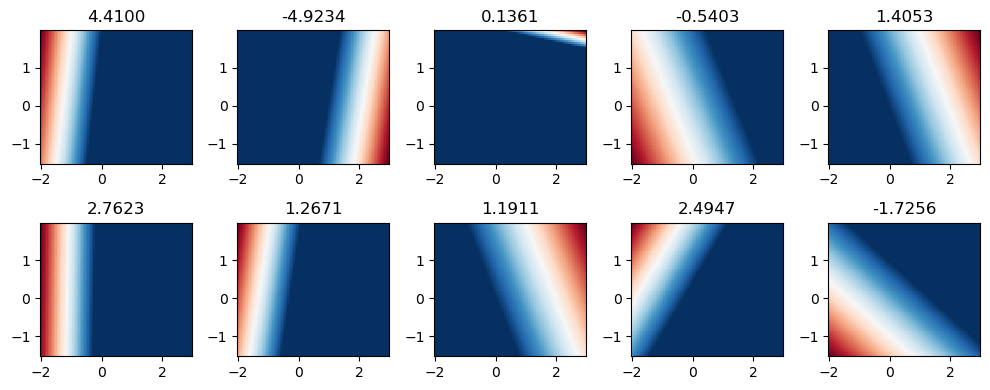

In [63]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4), tight_layout=True)

for ax_, layer, w in zip(ax.ravel(), model[0](x_test).T, model[2].weight.detach()[0]):
    ax_.pcolormesh(xx1_test, xx2_test, 
                   nn.ReLU()(layer).reshape(xx1_test.shape).detach(), 
                   cmap=plt.cm.RdBu_r)
    ax_.set_title(f"{w.item():0.4f}")

:::{note}

La capa de salida combina los hiperplanos de la capa oculta para formar un circulo. Sobre cada neurona oculta se muestra su peso en la capa de salida. Mientras más cercano a cero, menos relevante es su aporte.

:::

## Diagnósticos a partir de curvas de aprendizaje

Podemos diagnosticar el entrenamiento observando la evolución de la función de costo 

:::{important}

Siempre visualiza la loss en ambos conjuntos: entrenamiento y validación

:::

Veamos algunos casos

**Ambas curvas en descenso**

Si las curvas se ven así:

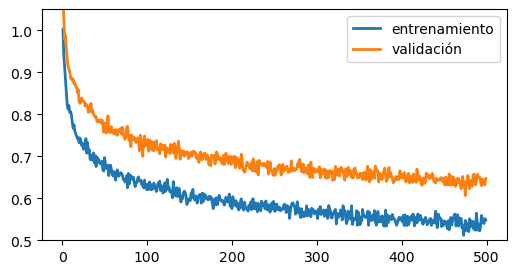

In [26]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

En este caso deberías continuar con el entrenamiento, pues no hay señal de convergencia

**Sobreajuste temprano**

Si las curvas se ven así:

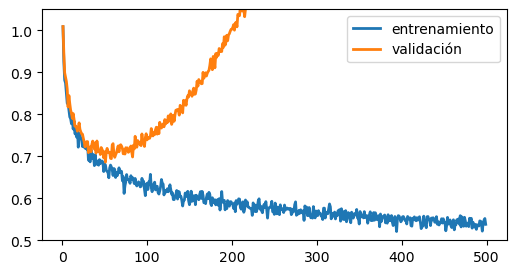

In [27]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.00001*(epochs)**2 +0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

Significa que tu modelo se ha sobreajustado, por ende:

- Implementa un modelo más sencillo
- Consigue más datos
- Considera utilizar regularización 

**Error en el código o mal punto de partida**

Si tus curvas se ven así:

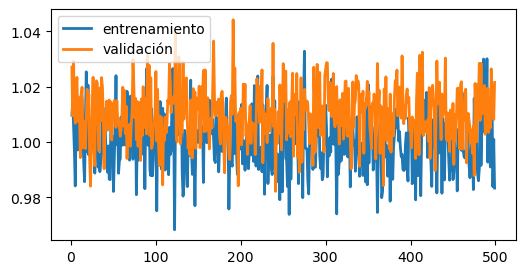

In [28]:
epochs = np.arange(1, 500)
loss_train = 1.0 + 0.01*np.random.randn(len(epochs))
loss_valid = 1.0 + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
#ax.set_ylim([0.5, 1.05])
plt.legend();

Revisa que tu código no tenga *bugs*, causas comunes de error: 

- el modelo no esté recibiendo adecuadamente los datos y/o la etiqueta 
- los datos tiene un rango muy grande y los gradientes explotan: normaliza los datos
- la función de costo no es la adecuada para el problema 
- la taza de aprendizaje es demasiado alta

También puede deberse a una muy mala inicialización aleatoria, reinicia el entrenamiento para comprobar si es el caso